# 共起ネットワークの作成

In [1]:
from pathlib import Path
import re
import collections
import pandas as pd
import MeCab
import mojimoji
import neologdn
import unicodedata
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## パラメータの設定

In [3]:
data_dir_path = Path('data')
result_dir_path = Path('result')

if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## 関数定義

In [4]:
def get_stopword_lsit(write_file_path):

    if not write_file_path.exists():
        url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
        urllib.request.urlretrieve(url, write_file_path)

    with open(write_file_path, 'r', encoding='utf-8') as file:
        stopword_list = [word.replace('\n', '') for word in file.readlines()]

    return stopword_list

In [5]:
def get_noun_words_from_sentence(sentence, mecab, stopword_list=[]):
    return [
        x.split('\t')[0] for x in mecab.parse(sentence).split('\n') if len(x.split('\t')) > 1 and \
         '名詞' in x.split('\t')[3] and x.split('\t')[0] not in stopword_list
    ]

In [6]:
def split_sentence(sentence, mecab, stopword_list):
    sentence = neologdn.normalize(sentence)
    sentence = unicodedata.normalize("NFKC", sentence)
    words = get_noun_words_from_sentence(
        sentence=sentence, mecab=mecab, stopword_list=stopword_list
    )
    words = list(map(lambda x: re.sub(r'\d+\.*\d*', '0', x.lower()), words))
    return words

## データの取得

In [7]:
with open(data_dir_path.joinpath('gakumonno_susume.txt'), 'r', encoding='utf-8') as file:
    lines = file.readlines()
    
sentences = []
for sentence in lines:
    texts = sentence.split('。')
    sentences.extend(texts)

## テキストを前処理して、名詞だけを残す

In [8]:
mecab = MeCab.Tagger('-Ochasen')

stopword_list = get_stopword_lsit(data_dir_path.joinpath('stopword_list.txt'))

noun_sentences = []
for sentence in sentences:
    noun_sentences.append(
        split_sentence(sentence=sentence, mecab=mecab, stopword_list=stopword_list)
    )

In [9]:
for words in noun_sentences[:5]:
    print(words)

['天']
['天', 'みな', '位', '貴', '賤', 'きせん', '上下', '差別', '万物', '霊', '身', '心', '働き', '天地', '物', '資', '衣食住', '自由自在', '妨げ', '安楽', 'この世', '趣意']
['人間', '世界', 'おろか', '貴人', '下人', '有様', '雲', '泥', 'ど', 'ろ', '相違']
['次第', '明らか']
['実', '語', '教', 'ご', 'きょう', '智', '智', '愚人']


１語しかない文は除く

In [10]:
noun_sentences = list(filter(lambda x: len(x) > 1 and '見出し' not in x, noun_sentences))

## 共起ネットワークのためのデータ整形

同じ文章内で出現度が高い組み合わせがわかる共起ネットワークを作るため、<br>
文章内の単語のすべての組み合わせを作り、文字列でソートする。<br>
その後、文章ごとのリストから１次元のリストに変換する。

In [11]:
combination_sentences = [list(itertools.combinations(words, 2)) for words in noun_sentences]
combination_sentences = [[tuple(sorted(combi)) for combi in combinations] for combinations in combination_sentences]
tmp = []
for combinations in combination_sentences:
    tmp.extend(combinations)
combination_sentences = tmp

In [12]:
combination_sentences[:5]

[('みな', '天'), ('位', '天'), ('天', '貴'), ('天', '賤'), ('きせん', '天')]

### Jaccard係数の算出

In [13]:
def make_jaccard_coef_data(combination_sentences):

    combi_count = collections.Counter(combination_sentences)

    word_associates = []
    for key, value in combi_count.items():
        word_associates.append([key[0], key[1], value])

    word_associates = pd.DataFrame(word_associates, columns=['word1', 'word2', 'intersection_count'])

    words = []
    for combi in combination_sentences:
        words.extend(combi)

    word_count = collections.Counter(words)
    word_count = [[key, value] for key, value in word_count.items()]
    word_count = pd.DataFrame(word_count, columns=['word', 'count'])

    word_associates = pd.merge(
        word_associates,
        word_count.rename(columns={'word': 'word1'}),
        on='word1', how='left'
    ).rename(columns={'count': 'count1'}).merge(
        word_count.rename(columns={'word': 'word2'}),
        on='word2', how='left'
    ).rename(columns={'count': 'count2'}).assign(
        union_count=lambda x: x.count1 + x.count2 - x.intersection_count
    ).assign(jaccard_coef=lambda x: x.intersection_count / x.union_count).sort_values(
        ['jaccard_coef', 'intersection_count'], ascending=[False, False]
    )
    
    return word_associates

In [14]:
jaccard_coef_data = make_jaccard_coef_data(combination_sentences)

In [15]:
jaccard_coef_data.head(10)

,word1,word2,intersection_count,count1,count2,union_count,jaccard_coef
5137,小幡,篤次郎,1,1,1,1,1.000000
8267,売り言葉,買い言葉,1,1,1,1,1.000000
29543,不可思議,妙,1,2,2,3,0.333333
30301,仏書,罪業,1,2,2,3,0.333333
30302,仏書,女人,1,2,2,3,0.333333
30303,女人,罪業,1,2,2,3,0.333333
30306,大罪,科人,1,2,2,3,0.333333
31285,破廉恥,鉄面皮,1,1,3,3,0.333333
34234,恩賜,陰徳,1,2,2,3,0.333333
51909,キリン,フラン,1,2,2,3,0.333333


In [16]:
group_values = [0, 0.01, 0.02, 0.04, float('inf')]

plot_data = jaccard_coef_data.copy()
plot_data['group_num'] = 0
group_names = []
for i in range(len(group_values) - 1):

    plot_data['group_num'] = plot_data.apply(
        lambda x: i + 1 if group_values[i] <= x['jaccard_coef'] and x['jaccard_coef'] < group_values[i + 1] else x['group_num'],
        axis=1
    )
    group_names.append((group_values[i], group_values[i + 1]))
    
plot_data = plot_data.groupby('group_num')['jaccard_coef'].count().reset_index().rename(
    columns={'jaccard_coef': 'n_combi'}
).assign(rate=lambda x: x.n_combi / x.n_combi.sum()).assign(
    rate_cumsum=lambda x: x.rate.cumsum()
)
plot_data = pd.concat([
    pd.DataFrame(group_names, columns=['jaccard_lower', 'jaccard_upper']),
    plot_data
], axis=1)

In [17]:
plot_data

,jaccard_lower,jaccard_upper,group_num,n_combi,rate,rate_cumsum
0,0.00,0.01,1,57028,0.794041,0.794041
1,0.01,0.02,2,10411,0.144960,0.939000
2,0.02,0.04,3,3263,0.045433,0.984433
3,0.04,inf,4,1118,0.015567,1.000000


## 共起ネットワークを描く

In [40]:
def plot_network(
    data, edge_threshold=0., fig_size=(15, 15),
    fontfamily='Hiragino Maru Gothic Pro', fontsize=14,
    coefficient_of_restitution=0.15,
    image_file_path=None
):

    nodes = list(set(data['node1'].tolist() + data['node2'].tolist()))
    
    plt.figure(figsize=fig_size)
    
    G = nx.Graph()
    # 頂点の追加
    G.add_nodes_from(nodes)

    # 辺の追加
    # edge_thresholdで枝の重みの下限を定めている
    for i in range(len(data)):
        row_data = data.iloc[i]
        if row_data['weight'] >= edge_threshold:
            G.add_edge(row_data['node1'], row_data['node2'], weight=row_data['weight'])

    # 孤立したnodeを削除
    isolated = [n for n in G.nodes if len([i for i in nx.all_neighbors(G, n)]) == 0]
    for n in isolated:
        G.remove_node(n)

    # k = node間反発係数
    pos = nx.spring_layout(G, k=coefficient_of_restitution)

    pr = nx.pagerank(G)
    # nodeの大きさ
    nx.draw_networkx_nodes(
        G, pos, node_color=list(pr.values()),
        cmap=plt.cm.Reds,
        alpha=0.7,
        node_size=[60000*v for v in pr.values()]
    )

    # 日本語ラベル
    nx.draw_networkx_labels(G, pos, font_size=fontsize, font_family=fontfamily, font_weight="bold")

    # エッジの太さ調節
    edge_width = [d["weight"] * 100 for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="darkgrey", width=edge_width)

    plt.axis('off')
    plt.tight_layout()
    
    if image_file_path:
        plt.savefig(image_file_path, dpi=300)

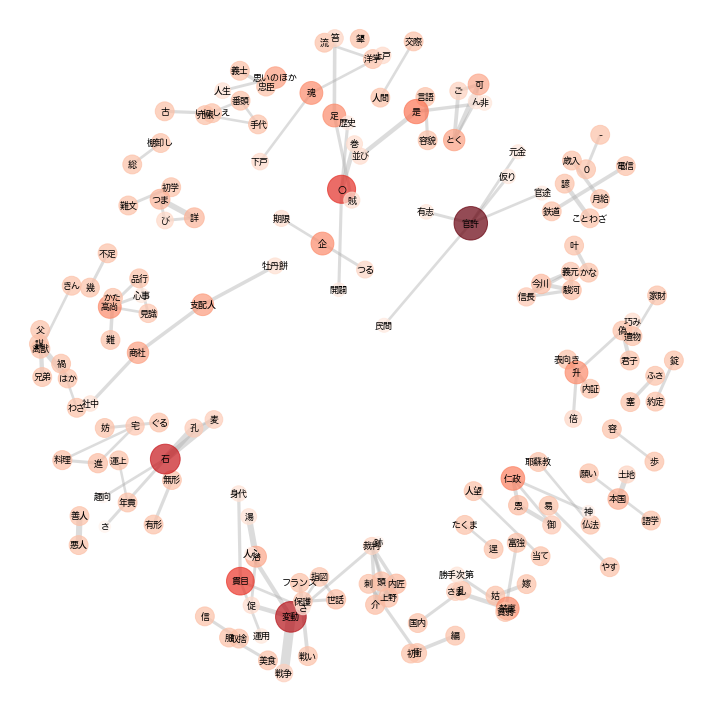

In [42]:
n_word_lower = 50
edge_threshold=0.025
plot_data = jaccard_coef_data.query(
    'count1 >= {0} and count2 >= {0}'.format(n_word_lower)
).rename(
    columns={'word1': 'node1', 'word2': 'node2', 'jaccard_coef': 'weight'}
)

plot_network(
    data=plot_data,
    edge_threshold=edge_threshold,
    fig_size=(10, 10),
    fontsize=9,
    fontfamily='Hiragino Maru Gothic Pro',
    coefficient_of_restitution=0.08,
    image_file_path=result_dir_path.joinpath('co_occurence_network.png')
)

## 